# Comparing ANHA4 Ba with Obs

This is the notebook I used to compare modeled Ba with field observations. - 2016/01/26

Steps:
* Match the date: usually model = year-Aug, obs=year-Aug-date
* Match lon/lat: nearest neighbor search
* Match depth: ANHA4 T grid depth linearly interpolated into profile depth

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
#sys.setdefaultencoding('utf8')
sys.path.insert(0, '../../_libs/')

In [35]:
import glob
#import pyproj
import datetime
import scipy.io
import numpy as np
import netCDF4 as nc
import NEMO_tools as Nts
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, cm
% matplotlib inline

In [4]:
from NEMO_tools import int_profile, bin_profile, find_inland, reporj_NEMOgrid

In [5]:
np.set_printoptions(threshold='nan')

In [54]:
def Get_prof_id(dep):
    test_id = np.zeros(dep.shape)
    count = 1.0
    for i in range(len(dep)-1):
        if(dep[i+1] > dep[i]):
            test_id[i] = count
            test_id[i+1] = count
        else:
            test_id[i] = count
            count += 1.0
            test_id[i+1] = count
    return test_id

In [72]:
def Get_model_var(nav_lon, nav_lat, deptht, Ba, prof_lons, prof_lats, prof_deps, prof_Ba):
    prof_id = Get_prof_id(prof_deps)    
    N = prof_id.max().astype(int)
    prof_model = np.zeros(prof_Ba.shape)
    for i in range(N):
        indx, indy = Nts.nearest_search(nav_lon, nav_lat, prof_lons[prof_id==i+1][0], prof_lats[prof_id==i+1][0])
        model_prof = Ba[:, indx, indy]
        prof_model[prof_id==i+1] = np.interp(prof_deps[prof_id==i+1], deptht, model_prof)
    return prof_model

In [36]:
from dateutil.relativedelta import relativedelta
base = datetime.datetime(2002, 1, 1)
date_list = [base + relativedelta(months=x) for x in range(144)]

# Model output

In [32]:
FName = '/ocean/yingkai/GEOTRACES/Simulations/BASE01_1m_20020101_20131231_ptrc_T.nc'

In [33]:
ptrc_obj = nc.Dataset(FName)
#Ba = np.squeeze(ptrc_obj.variables['Ba'][66, 0, :, :]) #67
#Ba[Ba==0]=np.nan

nav_lat = ptrc_obj.variables['nav_lat'][:]
nav_lon = ptrc_obj.variables['nav_lon'][:]
deptht = ptrc_obj.variables['deptht'][:]

In [56]:
xp = np.array([1, 2, 3, 4, 5])
fp = xp*2
np.interp(2.5, xp, fp)

5.0

# Comparison done by field proj.

## GEOTRACES Int. Polar Year cruise 11 (GIPY11)

In [152]:
MAT = scipy.io.loadmat('../../_data/MAT files/Processed samples/GIPY11_Ba.mat')
GIPY_lons = MAT['Ba_records'][:, 0]
GIPY_lats = MAT['Ba_records'][:, 1]
GIPY_deps = MAT['Ba_records'][:, 2]
GIPY_Ba   = MAT['Ba_records'][:, 3]
#
GIPY_lons[GIPY_lons>180]=GIPY_lons[GIPY_lons>180]-360
GIPY_time = 67 # 2007-08
#
Ba = np.squeeze(ptrc_obj.variables['Ba'][GIPY_time, :, :, :])
Ba[Ba==0]=np.nan
#
GIPY_model = Get_model_var(nav_lon, nav_lat, deptht, Ba, GIPY_lons, GIPY_lats, GIPY_deps, GIPY_Ba)

## Beaufort Gyre Exploration Proj. (BGEP) 2003-2005 cruises

In [153]:
MAT = scipy.io.loadmat('../../_data/MAT files/Processed samples/BGEP_Ba.mat')
x03 = MAT['Ba2003'][:, 1][::-1]; y03 = MAT['Ba2003'][:, 0][::-1]; z03 = MAT['Ba2003'][:, 2][::-1] 
Ba03 = MAT['Ba2003'][:, 3][::-1]
#
BGEP03_time = 19 # 2003-08
#
Ba = np.squeeze(ptrc_obj.variables['Ba'][BGEP03_time, :, :, :])
Ba[Ba==0]=np.nan
#
BGEP03_model = Get_model_var(nav_lon, nav_lat, deptht, Ba, x03, y03, z03, Ba03)

In [154]:
x04 = MAT['Ba2004'][:, 1][::-1]; y04 = MAT['Ba2004'][:, 0][::-1]; z04 = MAT['Ba2004'][:, 2][::-1]
Ba04 = MAT['Ba2004'][:, 3][::-1]
#x04[Ba04<0]=np.nan; y04[Ba04<0]=np.nan; z04[Ba04<0]=np.nan; Ba04[Ba04<0]=np.nan
#
BGEP04_time = 31 # 2003-08
#
Ba = np.squeeze(ptrc_obj.variables['Ba'][BGEP04_time, :, :, :])
Ba[Ba==0]=np.nan
#
BGEP04_model = Get_model_var(nav_lon, nav_lat, deptht, Ba, x04, y04, z04, Ba04)

In [155]:
x05 = MAT['Ba2005'][:, 1]; y05 = MAT['Ba2005'][:, 0]; z05 = MAT['Ba2005'][:, 2]; Ba05 = MAT['Ba2005'][:, 3]
#
BGEP05_time = 43 # 2003-08
#
Ba = np.squeeze(ptrc_obj.variables['Ba'][BGEP05_time, :, :, :])
Ba[Ba==0]=np.nan
#
BGEP05_model = Get_model_var(nav_lon, nav_lat, deptht, Ba, x05, y05, z05, Ba05)

## R/V Healy Cruise (HLY-03-01) North Atlantic branch

In [156]:
MAT = scipy.io.loadmat('../../_data/MAT files/Processed samples/HLY_Ba.mat')
xH = np.squeeze(MAT['lon'][:]); yH = np.squeeze(MAT['lat'][:]); zH = np.squeeze(MAT['dep'][:])
BaH = np.squeeze(MAT['Ba'][:])
#
HLY_time = 19 # 2003-08
#
Ba = np.squeeze(ptrc_obj.variables['Ba'][HLY_time, :, :, :])
Ba[Ba==0]=np.nan
#
HLY_model = Get_model_var(nav_lon, nav_lat, deptht, Ba, xH, yH, zH, BaH)

## Chesapeake Bio. Lab. (CBL) cruise 32P

time: 2002-08-19

In [157]:
MAT = scipy.io.loadmat('../../_data/MAT files/Processed samples/CBL_Ba.mat')
xC = np.squeeze(MAT['lon'][:]); yC = np.squeeze(MAT['lat'][:]); zC = np.squeeze(MAT['dep'][:])
BaC = np.squeeze(MAT['Ba'][:])
#
CBL_time = 7 # 2002-08
#
Ba = np.squeeze(ptrc_obj.variables['Ba'][CBL_time, :, :, :])
Ba[Ba==0]=np.nan
#
CBL_model = Get_model_var(nav_lon, nav_lat, deptht, Ba, xC, yC, zC, BaC)

## Out of range (X)

* ARK09, time = 1993
* ARK14, time = 1998
* NPEO, time = 2000-2004 but mixed up
* Gauy's thesis, time = earlier than 1998 

In [117]:
## time = 1993 (X)
#MAT = scipy.io.loadmat('../../_data/MAT files/Processed samples/ARK09_Ba.mat')
#xA9 = np.squeeze(MAT['lon'][:]); yA9 = np.squeeze(MAT['lat'][:]); zA9 = np.squeeze(MAT['dep'][:]); BaA9 = np.squeeze(MAT['Ba'][:])

In [118]:
## time = 1998 (X)
#MAT = scipy.io.loadmat('../../_data/MAT files/Processed samples/ARK14_Ba.mat')
#xA14 = np.squeeze(MAT['lon'][:]); yA14 = np.squeeze(MAT['lat'][:]); zA14 = np.squeeze(MAT['dep'][:]); BaA14 = np.squeeze(MAT['Ba'][:])

In [119]:
## time = 2000 - 2004 (mixed up, X)
#MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/NPEO_Ba.mat')
#xNPEO = np.squeeze(MAT['lon'][:]); yNPEO = np.squeeze(MAT['lat'][:]); zNPEO = np.squeeze(MAT['dep'][:]); BaNPEO = np.squeeze(MAT['Ba'][:])

In [120]:
## time = earlier than 1997
#MAT = scipy.io.loadmat('../../_data/MAT files/Processed samples/ARC_Ba.mat')
#xARC = np.squeeze(MAT['lon'][:]); yARC = np.squeeze(MAT['lat'][:]); zARC = np.squeeze(MAT['dep'][:]); BaARC = np.squeeze(MAT['Ba'][:])

# Comparison plots (draft)

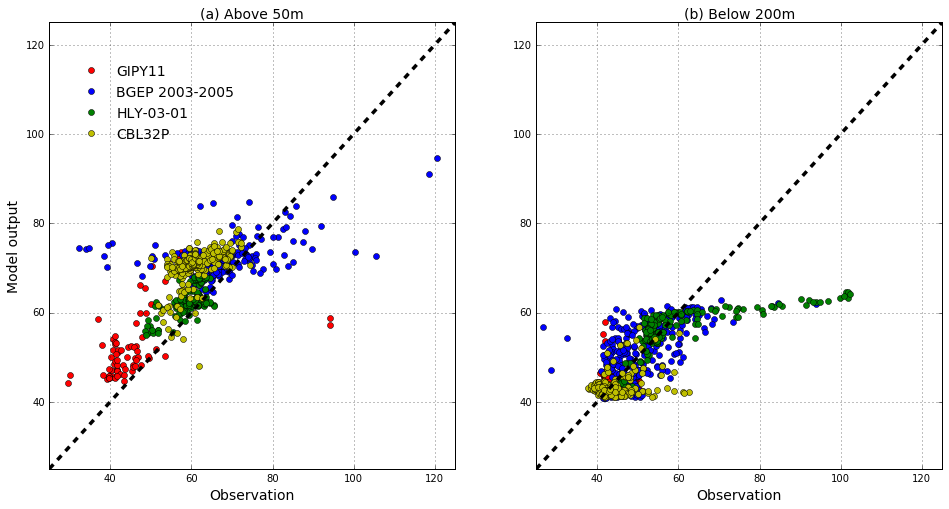

In [190]:
fig = plt.figure(figsize=(16, 8))
ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
#
ax1.grid(); ax2.grid()
ax1.set_xlim([25, 125]); ax2.set_xlim([25, 125])
ax1.set_ylim([25, 125]); ax2.set_ylim([25, 125])
ax1.set_xlabel('Observation', fontsize=14); ax2.set_xlabel('Observation', fontsize=14)
ax1.set_ylabel('Model output', fontsize=14)
d = 50.0;
ax1.plot(GIPY_Ba[GIPY_deps<d], GIPY_model[GIPY_deps<d], 'ro', ms=6, label='GIPY11')
ax1.plot(Ba03[z03<d], BGEP03_model[z03<d], 'bo', ms=6, label='BGEP 2003-2005')
ax1.plot(Ba04[z04<d], BGEP04_model[z04<d], 'bo', ms=6)
ax1.plot(Ba05[z05<d], BGEP05_model[z05<d], 'bo', ms=6)
ax1.plot(BaH[zH<d], HLY_model[zH<d], 'go', ms=6, label='HLY-03-01')
ax1.plot(BaC[zC<d], CBL_model[zC<d], 'yo', ms=6, label='CBL32P')
ax1.plot([25, 125], [25, 125], 'k--', lw=3.5)
LG=ax1.legend(bbox_to_anchor=(0.02, 0.95), loc=2, borderaxespad=1, numpoints=1, prop={'size':14}); LG.draw_frame(False)
ax1.set_title('(a) Above 50m', fontsize=14)
d = 200.0;
ax2.plot(GIPY_Ba[GIPY_deps>d], GIPY_model[GIPY_deps>d], 'ro', ms=6, label='GIPY11')
ax2.plot(Ba03[z03>d], BGEP03_model[z03>d], 'bo', ms=6, label='BGEP 2003-2005')
ax2.plot(Ba04[z04>d], BGEP04_model[z04>d], 'bo', ms=6)
ax2.plot(Ba05[z05>d], BGEP05_model[z05>d], 'bo', ms=6)
ax2.plot(BaH[zH>d], HLY_model[zH>d], 'go', ms=6, label='HLY-03-01')
ax2.plot(BaC[zC>d], CBL_model[zC>d], 'yo', ms=6, label='CBL32P')
ax2.plot([25, 125], [25, 125], 'k--', lw=3.5)
ax2.set_title('(b) Below 200m', fontsize=14)

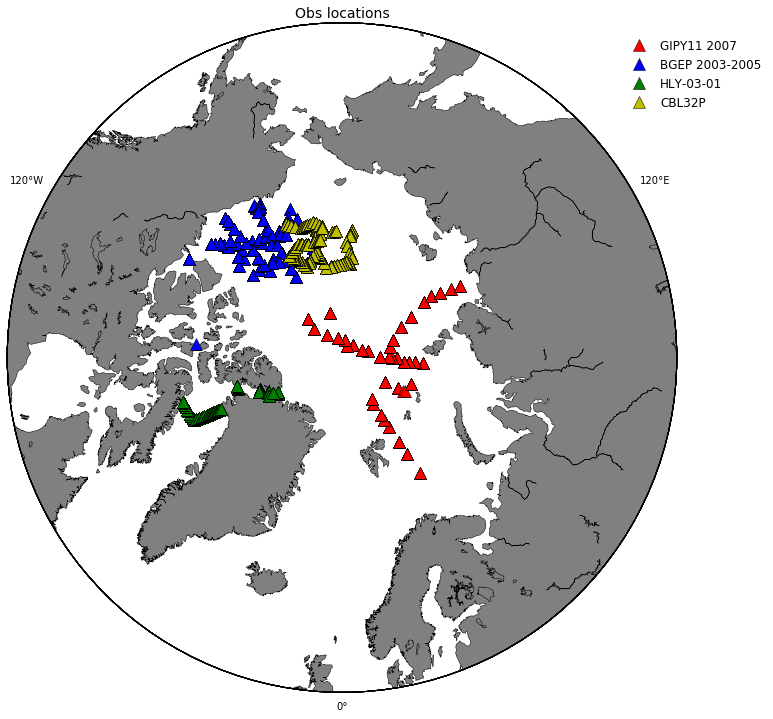

In [189]:
fig=plt.figure(figsize=(12, 12));
ax = fig.gca()

proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=0, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 120), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=0.5, color='k')

GIPYx, GIPYy = proj(GIPY_lons, GIPY_lats)
BGEPx03, BGEPy03 = proj(x03, y03)
BGEPx04, BGEPy04 = proj(x04, y04)
BGEPx05, BGEPy05 = proj(x05, y05)
HLYx, HLYy = proj(xH, yH)
CBLx, CBLy = proj(xC, yC)

proj.plot(GIPYx, GIPYy, 'r^', label = 'GIPY11 2007', ms=12)
proj.plot(BGEPx03, BGEPy03, 'b^', label = 'BGEP 2003-2005', ms=12)
proj.plot(BGEPx04, BGEPy04, 'b^', ms=12)
proj.plot(BGEPx05, BGEPy05, 'b^', ms=12)
proj.plot(HLYx, HLYy, 'g^', label = 'HLY-03-01', ms=12)
proj.plot(CBLx, CBLy, 'y^', label = 'CBL32P', ms=12)

LG=ax.legend(bbox_to_anchor=(0.9, 1), loc=2, borderaxespad=1, numpoints=1); LG.draw_frame(False)
ax.set_title('Obs locations', fontsize=14)